In [1]:
# %load source/run_bracket.py
import deepchem as dc
import numpy as np
import pickle
import json
import os
import re

keywords = [
    'RankAdjOE',
    'RankAdjDE',
    'RankAdjTempo',
    'RankAPL_Off',
    'RankAPL_Def',
    'RankeFG_Pct',
    'RankDeFG_Pct',
    'RankTO_Pct',
    'RankDTO_Pct',
    'RankOR_Pct',
    'RankDOR_Pct',
    'RankFT_Rate',
    'RankDFT_Rate',
    'RankDFT_Rate',
    'RankFG3Pct',
    'RankFG3Pct&od=d',
    'RankFG2Pct',
    'RankFG2Pct&od=d',
    'RankFTPct',
    'RankFTPct&od=d',
    'RankBlockPct',
    'RankBlockPct&od=d',
    'RankStlRate',
    'RankStlRate&od=d',
    'RankF3GRate',
    'RankF3GRate&od=d',
    'RankARate',
    'RankARate&od=d',
    'RankOff_3',
    'RankDef_3',
    'RankOff_2',
    'RankDef_2',
    'RankOff_1',
    'RankDef_1',
    'RankSOSO',
    'RankSOSD',
    'ExpRank',
    'SizeRank',
]

def get_feature_vector(html_str):
    fv = []
    for keyword in keywords:
        pattern = '%s.*>(\d+\.\d+)' % keyword
        val = re.findall(pattern, html_str)[-1]
        fv.append(float(val))
    return fv

def score_to_diff(s, neg=False):
    s = [float(x) for x in s.split('-')]
    v = abs(s[0] - s[1])
    if neg:
        return -1 * v
    return v

def get_wins_losses(html_str):
    pat = 'team.php.*?=(.*?)".*>W<.* (\d+-\d+).*\n'
    wins = re.findall(pat, html_str)
    wins = [(x[0], score_to_diff(x[1])) for x in wins]

    pat = 'team.php.*?=(.*?)".*>L<.* (\d+-\d+).*\n'
    losses = re.findall(pat, html_str)
    losses = [(x[0], score_to_diff(x[1], True)) for x in losses]
    return wins + losses

def parse_html_file(html_str):
    """
    return feature_vector, list of (oppenent, +- score)
    """
    fv = get_feature_vector(html_str)
    wl = get_wins_losses(html_str)
    return fv, wl

def get_team_dict():
    html_files = os.listdir('raw_data')
    html_files = list(filter(lambda x: x.find('2017') == -1, html_files))
    d = {}
    for html_file in html_files:
        html_str = open('raw_data/%s' % html_file).read()
        team_name = html_file[:-5]
        d[team_name] = parse_html_file(html_str)
    return d

def get_transformers():
    transformers = pickle.load(open('transformers.pkl', 'rb'))
    return transformers

def play_game(t1, t2, team_dict, keys=['27_all_data']):
    fv1 = team_dict[t1][0]
    fv2 = team_dict[t2][0]
    g1 = fv1 + fv2
    g2 = fv2 + fv1
    ds = dc.data.NumpyDataset(np.array([g1,g2]))
    for trans in get_transformers():
        ds = trans.transform(ds)
    y_pred = max_min_ensemble(predict(keys, ds))[:,0]
    final_score = y_pred[0] + -1 * y_pred[1]
    print(final_score)
    if final_score > 0:
        return t1, abs(final_score)
    return t2, abs(final_score)

def play_tourney(bracket):
    team_dict = get_team_dict()
    teams_left = bracket
    all_winners, all_scores = list(), list()
    while len(teams_left) > 1:
        print(len(teams_left))
        winners = []
        scores = []
        for i in range(0, len(teams_left), 2):
            t1, t2 = teams_left[i], teams_left[i+1]
            winner, score = play_game(t1, t2, team_dict)
            winners.append(winner)
            scores.append(score)
        teams_left = winners
        all_winners.append(winners)
        all_scores.append(scores)
    return all_winners, all_scores

def predict(keys, ds):
    retval = None
    for key in keys:
        for fold in range(5):
            model_dir = 'models/%s/%s' % (key, fold)
            print(model_dir)
            model = dc.models.TensorGraph.load_from_dir(model_dir)
            y_pred = model.predict(ds)
            y_pred = np.reshape(y_pred, newshape=(y_pred.shape[0], 1))
            if retval is None:
                retval = y_pred
            else:
                retval = np.concatenate([retval, y_pred], axis=1)
    return retval

def max_min_ensemble(y_pred):
  results = []
  for row in range(y_pred.shape[0]):
    r_dat = y_pred[row, :].tolist()
    r_dat.remove(max(r_dat))
    r_dat.remove(min(r_dat))
    mean = np.mean(r_dat)
    std = np.std(r_dat)
    results.append((mean, std))
  return np.array(results)

def get_bracket(year=208):
    bracket = [
        'Virginia',
        'UMBC',
        'Creighton',
        'Kansas+St.',
        'Kentucky',
        'Davidson',
        'Arizona',
        'Buffalo',
        'Miami+FL',
        "Loyola+Chicago",
        'Tennessee',
        'Wright+St.',
        'Nevada',
        'Texas',
        'Cincinnati',
        'Georgia+St.',

        'Xavier',
        'Texas+Southern',
        'Missouri',
        'Florida+St.',
        'Ohio+St.',
        'South+Dakota+St.',
        'Gonzaga',
        'UNC+Greensboro',
        'Houston',
        'San+Diego+St.',
        'Michigan',
        'Montana',
        'Texas+A%26M',
        'Providence',
        'North+Carolina',
        'Lipscomb',

        'Villanova',
        'Radford',
        'Virginia+Tech',
        'Alabama',
        'West+Virginia',
        'Murray+St.',
        'Wichita+St.',
        'Marshall',
        'Florida',
        'UCLA',
        'Texas+Tech',
        'Stephen+F.+Austin',
        'Arkansas',
        'Butler',
        'Purdue',
        'Cal+St.+Fullerton',

        'Kansas',
        'Penn',
        'Seton+Hall',
        'North+Carolina+St.',
        'Clemson',
        'New+Mexico+St.',
        'Auburn',
        'College+of+Charleston',
        'TCU',
        'Arizona+St.',
        'Michigan+St.',
        'Bucknell',
        'Rhode+Island',
        'Oklahoma',
        'Duke',
        'Iona'
    ]
    return bracket

def run_full_bracket():
    bracket = get_bracket()
    all_winners, all_scores = play_tourney(bracket)
    print(all_winners)
    print(all_scores)
    with open('2018_final_winners.json', 'w') as fout:
        s = json.dumps(all_winners)
        fout.write(s)
    with open('2018_final_scores.json', 'w') as fout:
        s = json.dumps(all_scores)
        fout.write(s)

def play_one_game(t1, t2):
    team_dict = get_team_dict()
    retval = play_game(t1, t2, team_dict)
    return retval[0], retval[1] * 16.0


if __name__ == "__main__":
    pass
    #run_full_bracket()
    #print(play_one_game('Virginia', 'Arizona'))
    #print(play_one_game('Virginia', 'Kentucky'))
    #print(play_one_game('Duke', 'Michigan+St.'))
    #print(play_one_game('Duke', 'Kansas'))
    #print(play_one_game('Radford', 'LIU+Brooklyn'))
    #print(play_one_game('Arizona+St.', 'Syracuse'))
    #print(play_one_game('St.+Bonaventure', 'UCLA'))
    #print(play_one_game('North+Carolina+Central', 'Texas+Southern'))




/home/leswing/miniconda3/envs/deepchem/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
transformers = pickle.load(open('transformers.pkl', 'rb'))
    

In [3]:
def reverse_ds(ds):
    X = ds.X
    y = ds.y
    y = y * -1
    l = X.shape[-1] //2
    t1 = X[:,0:l]
    t2 = X[:,l:]
    new_x = np.concatenate([t2,t1], axis=1)
    return dc.data.NumpyDataset(new_x,  y, ds.w, ds.ids)

def get_y_pred_for_fold(fold):
    fold=0
    ds = dc.data.DiskDataset('datasets/2018_2017_folds/valid%s' % fold)
    model_dir = 'models/27_all_data/%s' %  fold
    model = dc.models.TensorGraph.load_from_dir(model_dir)
    y_pred1 = model.predict(ds)
    y_pred2 = model.predict(reverse_ds(ds)) * -1
    y_pred = y_pred1 + y_pred2
    y_pred = y_pred * 0.5
    y_pred = np.squeeze(y_pred)
    return y_pred, np.squeeze(ds.y)

cv_scores = []
for i in range(5):
    cv_scores.append(get_y_pred_for_fold(i))
full_pred = np.concatenate([x[0] for x in cv_scores]) * transformers[-1].y_stds[0]
full_true = np.concatenate([x[1] for x in cv_scores]) * transformers[-1].y_stds[0]

Loading dataset from disk.
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
Loading dataset from disk.
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
Loading dataset from disk.
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
Loading dataset from disk.
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
Loading dataset from disk.
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375


In [4]:
def kround(number):
    return round(number * 2) / 2

diff_buckets = [kround(x) for x in full_pred.tolist()]




In [5]:
# I want to give p(win|X==x) for each bucket
d = {}
for diff, t in zip(diff_buckets, full_true):
    if diff not in d:
        d[diff] = np.array([0,0])
    if t > 0:
        d[diff][1] += 1
    else:
        d[diff][0] += 1
    

In [6]:
keys = sorted(set([abs(x) for x in d.keys()]))
p_win = []
for k in keys:
    if k not in d or -k not in d:
        p_win.append(1.0)
        continue
    floss, cwin = d[k][0], d[k][1]
    closs, fwin = d[-1*k][0], d[-1*k][1]
    prob = (closs + cwin) / (floss + cwin + closs + fwin)
    p_win.append(prob)
total_games = []
for k in keys:
    total = 0
    if k in d:
        total = total + d[k][0] + d[k][1]
    if -k in d:
        total = total + d[-1*k][0] + d[-1*k][1]
    total_games.append(total)

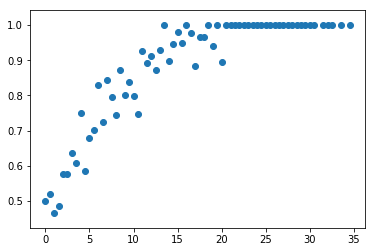

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(keys, p_win)

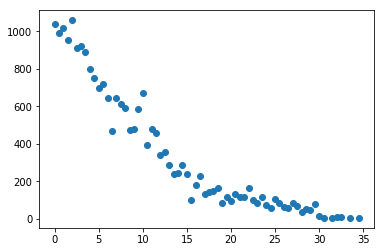

In [9]:
plt.scatter(keys, total_games)

(array([ 210.,  785., 1195., 3415., 5635., 5810., 3085., 1000.,  565.,
         130.]),
 array([-33.5, -26.7, -19.9, -13.1,  -6.3,   0.5,   7.3,  14.1,  20.9,
         27.7,  34.5]),
 <a list of 10 Patch objects>)

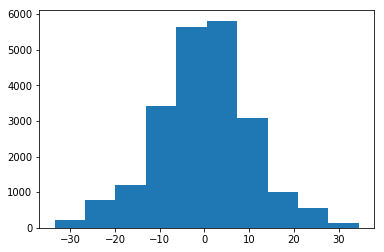

In [10]:
plt.hist(diff_buckets)

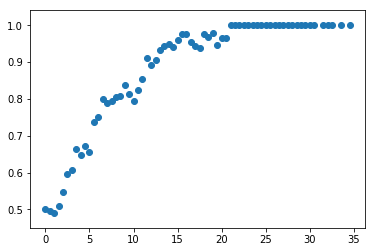

In [11]:
# pin and turn into sliding window to smooth out the probabilities
mp_win = [p_win[0]]
for i in range(1, len(p_win)-1):
    prob = p_win[i-1] + p_win[i] + p_win[i+1]
    prob = prob / 3.0
    mp_win.append(prob)
mp_win.append(p_win[-1])
plt.scatter(keys, mp_win)

In [51]:
import json
probabilities_keys = {k:v for k,v in zip(keys, mp_win)}
with open('probabilities.json', 'w') as fout:
    fout.write(json.dumps(probabilities_keys))
        

In [12]:
bracket = get_bracket()


In [13]:
t_ids = [x.strip().split(',') for x in open('kaggle/Teams.csv').readlines()][1:]

In [16]:
import re
def to_my_format(s):
    d1 = {
        "S Dakota St": "South+Dakota+St.",
        "TX Southern": "Texas+Southern",
        "SF Austin": "Stephen+F.+Austin",
        "CS Fullerton": "Cal+St.+Fullerton",
        "NC State": "North+Carolina+St.",
        "Col Charleston": "College+of+Charleston",
        "Long Island": "LIU+Brooklyn",
        "NC Central": 'North+Carolina+Central',
    }
    if s in d1:
        return d1[s]
    s = s.replace(' ', '+')
    s = s.replace('-', '+')
    s = s.replace('St', 'St.')
    s = s.replace('&', '%26')
    return s

def formated_ids(t_ids):
    retval = []
    for l in t_ids:
        k = l[0]
        v = l[1]
        retval.append([k, to_my_format(v)])
    return retval

def find_missing(t_ids, bracket):
    ft_ids = [x[1] for x in formated_ids(t_ids)]
    for team in bracket:
        if team not in ft_ids:
            print(team)
    
find_missing(t_ids, bracket)

In [17]:
first_four = [
    'Radford',
    "LIU+Brooklyn",
    'Arizona+St.', 
    'Syracuse',
    'St.+Bonaventure', 
    'UCLA',
    'North+Carolina+Central',
    'Texas+Southern'
]
find_missing(t_ids, first_four)

In [29]:
def create_name_map(k_ids, m_ids):
    ft_ids = [x[1] for x in formated_ids(t_ids)]
    d = {k: v for k,v in zip (ft_ids, [x[0] for x in t_ids])}
    return d
name_map = create_name_map(t_ids, bracket+first_four)

In [30]:
def create_game_vector(t1, t2, team_dict):
    fv1 = team_dict[t1][0]
    fv2 = team_dict[t2][0]
    return fv1 + fv2

def create_all_games_ds(team_list):
    team_list = list(set(team_list))
    print(len(team_list))
    team_dict = get_team_dict()
    ids = []
    fvs = []
    for i in range(len(team_list)):
        for j in range(i+1, len(team_list)):
            t1 = team_list[i]
            t2 = team_list[j]
            fv = create_game_vector(t1, t2, team_dict)
            fvs.append(fv)
            ids.append("%s,%s" % (t1,t2))
    ds = dc.data.NumpyDataset(np.array(fvs), None, None, ids)
    for trans in transformers:
        ds = trans.transform(ds)
    return ds

ds = create_all_games_ds(bracket + first_four)
    

68


In [31]:
def run_ds(ds):
    keys = ['27_all_data']
    y_pred1 = max_min_ensemble(predict(keys, ds))[:,0]
    y_pred2 = max_min_ensemble(predict(keys, reverse_ds(ds)))[:,0] * -1
    y_pred = y_pred1 + y_pred2
    y_pred = y_pred * 0.5
    return np.squeeze(y_pred)


In [32]:
y_pred = run_ds(ds)

models/27_all_data/0
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
models/27_all_data/1
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
models/27_all_data/2
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
models/27_all_data/3
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
models/27_all_data/4
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
models/27_all_data/0
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
models/27_all_data/1
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
models/27_all_data/2
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
models/27_all_data/3
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
models/27_all_data/4
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375


In [34]:
y_pred

array([ 0.11925658,  0.28583451,  0.33435438, ...,  1.20497608,
        0.2699785 , -1.0592254 ])

In [35]:
ds.ids

array(['West+Virginia,Ohio+St.', 'West+Virginia,Virginia+Tech',
       'West+Virginia,Miami+FL', ..., 'Texas+Tech,Radford',
       'Texas+Tech,Creighton', 'Radford,Creighton'], dtype=object)

In [38]:
def points_to_prob(points, probabilities_keys):
    points = kround(points)
    is_neg = False
    if points < 0:
        is_neg = True
        points *= -1
    if points not in probabilities_keys:
        return 1.0
    my_prob = probabilities_keys[points]
    if is_neg:
        return 1.0 - my_prob
    return my_prob
        

def format_kaggle(y_pred, ids, probabilities_keys, name_map):
    assert len(y_pred) == len(ids)
    retval = []
    for i in range(len(y_pred)):
        pred = y_pred[i] * transformers[-1].y_stds[0]
        t1, t2 = ids[i].split(',')
        t1, t2 = name_map[t1], name_map[t2]
        if t1 > t2:
            t1,t2 = t2,t1
            pred *= -1
        pred = points_to_prob(pred, probabilities_keys)
        retval.append([t1,t2,pred])
    return retval

probabilities_keys = {float(k):v for k,v in json.loads(open('probabilities.json').read()).items()}
final_answer = format_kaggle(y_pred, ds.ids, probabilities_keys, name_map)
    

(array([293., 198., 196., 211., 248., 275., 200., 175., 161., 321.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

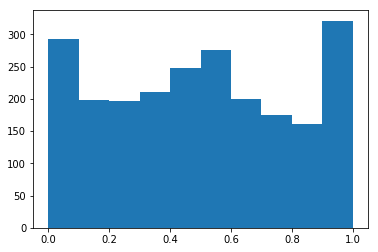

In [39]:
plt.hist([x[2] for x in final_answer])

In [40]:
def juice_prob(p):
    if p < 0.5:
        return max(p - 0.2, 0.0)
    return min(p + 0.2, 1.0)
juiced_answers = [[x[0], x[1], juice_prob(x[2])] for x in final_answer]

(array([687., 211., 248.,   0.,   0.,   0.,  45., 230., 200., 657.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

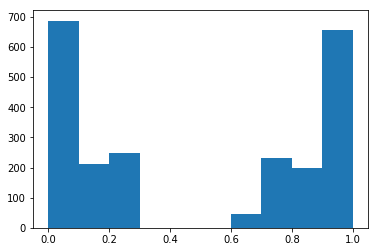

In [41]:
plt.hist([x[2] for x in juiced_answers])

In [42]:
with open('kaggle/submission_with_juice.csv', 'w') as fout:
    fout.write('id,pred\n')
    for t1,t2,pred in juiced_answers:
        s = "2018_%s_%s,%s\n" % (t1,t2,pred)
        fout.write(s)

In [43]:
with open('kaggle/submission_no_juice.csv', 'w') as fout:
    fout.write('id,pred\n')
    for t1,t2,pred in final_answer:
        s = "2018_%s_%s,%s\n" % (t1,t2,pred)
        fout.write(s)

In [44]:
rev_name_map = {v:k for k,v in name_map.items()}
for t1,t2,pred in final_answer:
    t1, t2 = rev_name_map[t1], rev_name_map[t2]
    if t1=='UMBC' and t2 =='Virginia':
        print(pred)

0.0


In [45]:
for t1,t2,pred in juiced_answers:
    t1, t2 = rev_name_map[t1], rev_name_map[t2]
    if t1 == "LIU+Brooklyn" and t2=='Radford':
        print(t1,t2)
        print(pred)

LIU+Brooklyn Radford
0.14445767195767195


In [46]:
# Time to do the monte_carlo

In [47]:
prob_dict = {}
for t1, t2, pred in final_answer:
    t1, t2 = rev_name_map[t1], rev_name_map[t2]
    if t1 not in prob_dict:
        prob_dict[t1] = {}
    if t2 not in prob_dict:
        prob_dict[t2] = {}
    prob_dict[t1][t2] = pred
    prob_dict[t2][t1] = 1 - pred

In [49]:
prob_sums = {}
for team1 in prob_dict.keys():
    prob_sums[team1] = 0
    for team2 in prob_dict.keys():
        if team1 == team2:
            continue
        prob_sums[team1] += prob_dict[team1][team2]
        

In [52]:
team_order = sorted([(k, v) for k,v in prob_sums.items()], key=lambda x : x[1], reverse=True)
team_order

[('Duke', 56.49476668108511),
 ('Virginia', 55.46013665094692),
 ('Villanova', 55.32094038222017),
 ('Purdue', 54.68983679157802),
 ('Michigan+St.', 51.89509347677425),
 ('Cincinnati', 51.89471909339151),
 ('North+Carolina', 51.30828733194282),
 ('Kansas', 48.82868645241731),
 ('Texas+Tech', 48.62854866456214),
 ('Michigan', 48.57147041656845),
 ('West+Virginia', 47.87046728406536),
 ('Xavier', 47.25972984152126),
 ('Gonzaga', 46.33451571838087),
 ('Tennessee', 45.875222313035266),
 ('Ohio+St.', 44.244043753310436),
 ('Auburn', 44.23974772183958),
 ('Wichita+St.', 43.50864823160918),
 ('Florida', 43.40844223035113),
 ('TCU', 43.1608058474353),
 ('Clemson', 42.05526622971046),
 ('Kentucky', 41.27847554924124),
 ('Arizona', 40.87502422129283),
 ('Creighton', 40.46223536990011),
 ('Texas+A%26M', 40.11584068572828),
 ('Butler', 40.04384363525346),
 ('Nevada', 39.97844779799067),
 ('Florida+St.', 39.34911539745066),
 ('Seton+Hall', 39.005252511230545),
 ('Houston', 38.896701554322114),
 ('V

In [56]:
n_teams = len(team_order)
heat_map = np.zeros((n_teams, n_teams))
for i in range(n_teams):
    for j in range(n_teams):
        if i == j:
            continue
        t1 = team_order[i][0]
        t2 = team_order[j][0]
        heat_map[i][j] = prob_dict[t1][t2]


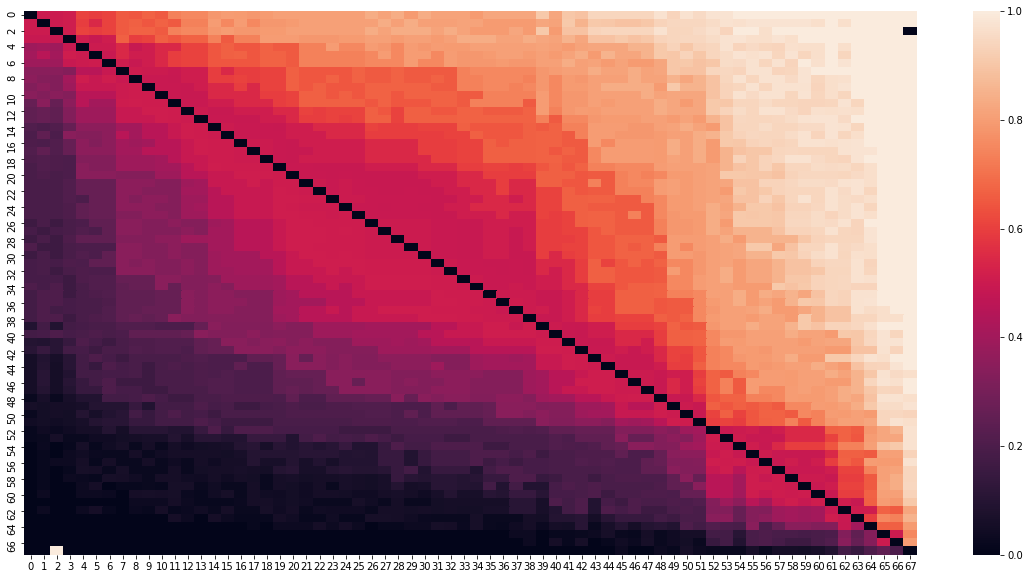

In [60]:
import seaborn
plt.figure(figsize=(20,10))
seaborn.heatmap(heat_map)

In [63]:
team_order[-1][0], team_order[2][0]

('North+Carolina+Central', 'Villanova')

In [64]:
prob_dict['North+Carolina+Central']['Villanova']

1.0

In [181]:
ds.ids.tolist().index("%s,%s" % ('Virginia', 'Villanova'))

831

In [182]:
y_pred[831]

-0.33877038955688432

In [184]:
play_game('Virginia', 'Villanova', get_team_dict())[1] * transformers[-1].y_stds[0]

models/27_all_data/0
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
models/27_all_data/1
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
models/27_all_data/2
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
models/27_all_data/3
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
models/27_all_data/4
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
0.0198142031829


0.30423245677046162

In [240]:
import random
def monte_play_game(t1, t2, prob_dict):
    r = random.random()
    p = prob_dict[t1][t2]
    if r < p:
        return t1
    return t2

def monte_carlo_run(bracket, prob_dict):
    teams_left = bracket
    results = []
    while len(teams_left) > 1:
        round_winners = {}
        winners = []
        for i in range(0, len(teams_left), 2):
            t1, t2 = teams_left[i], teams_left[i+1]
            winner = monte_play_game(t1, t2, prob_dict)
            winners.append(winner)
            round_winners[winner] = 1
        teams_left = winners
        results.append(round_winners)
    return results

def many_monte_carlo(bracket, prob_dict, num_runs=100):
    results = []
    for around in [32,16,8,4,2,1]:
        d = {}
        for team in bracket:
            d[team] = 0
        results.append(d)
    for _ in range(num_runs):
        l = monte_carlo_run(bracket, prob_dict)
        for i, d in enumerate(l):
            for k, v in d.items():
                results[i][k] += 1
    return results
                
        

In [248]:
n_runs = 1000000
runs = many_monte_carlo(bracket, prob_dict, n_runs)

In [249]:
def runs_to_table(runs, n):
    teams = list(runs[0].keys())
    retval = []
    for team in teams:
        l = [team]
        for i in range(len(runs)):
            l.append(runs[i][team] / n)
        retval.append(l)
    return retval

monte_table = runs_to_table(runs, n_runs)

In [252]:
monte_table = sorted(monte_table, key=lambda x: x[-3], reverse=True)
monte_table = sorted(monte_table, key=lambda x: x[-2], reverse=True)
monte_table = sorted(monte_table, key=lambda x: x[-1], reverse=True)

In [254]:
import json
with open('monte-carlo-tourney.json', 'w') as fout:
    fout.write(json.dumps(monte_table))

In [230]:
runs[1]['Cincinnati']

0

In [261]:
for row in monte_table:
    row = [row[0]] + ["%.2f" % x for x in row[1:]]
    print('|'+'|'.join(row)+'|')

|Virginia|1.00|0.80|0.65|0.43|0.30|0.17|
|Duke|1.00|0.84|0.57|0.43|0.24|0.15|
|Villanova|1.00|0.82|0.60|0.37|0.23|0.14|
|Purdue|1.00|0.80|0.53|0.31|0.18|0.10|
|Cincinnati|0.96|0.74|0.49|0.27|0.15|0.07|
|North+Carolina|1.00|0.76|0.46|0.29|0.15|0.07|
|Michigan+St.|0.94|0.67|0.31|0.20|0.09|0.05|
|Michigan|0.85|0.62|0.33|0.18|0.08|0.03|
|Kansas|0.94|0.66|0.39|0.16|0.07|0.03|
|Xavier|1.00|0.66|0.35|0.17|0.07|0.03|
|Texas+Tech|0.94|0.62|0.28|0.12|0.06|0.03|
|Tennessee|0.98|0.69|0.32|0.12|0.06|0.02|
|Gonzaga|0.91|0.50|0.28|0.14|0.05|0.02|
|West+Virginia|0.81|0.46|0.19|0.08|0.04|0.02|
|Auburn|0.96|0.54|0.28|0.08|0.03|0.01|
|Ohio+St.|0.81|0.43|0.23|0.10|0.03|0.01|
|Wichita+St.|0.94|0.49|0.14|0.05|0.02|0.01|
|Kentucky|0.75|0.42|0.11|0.05|0.02|0.01|
|Clemson|0.75|0.39|0.18|0.05|0.01|0.00|
|Arizona|0.81|0.46|0.12|0.04|0.02|0.00|
|Florida|0.67|0.29|0.09|0.03|0.01|0.00|
|TCU|0.66|0.24|0.06|0.03|0.01|0.00|
|Texas+A%26M|0.67|0.18|0.08|0.03|0.01|0.00|
|Houston|0.65|0.26|0.08|0.03|0.01|0.00|
|Creighton|